# Week 2

## Inladen

### Standaard datasets

Via tf.keras.datasets zijn de volgende datasets beschikbaar:
* boston-housing
* cifar-10
* cifar-100
* mnist
* fashion-mnist
* imdb
* reuters

In [2]:
import tensorflow as tf

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
assert x_train.shape == (60000, 28, 28)
assert x_test.shape == (10000, 28, 28)
assert y_train.shape == (60000,)
assert y_test.shape == (10000,)

### Gestructureerde data

De volgende manieren zijn voorbeelden van hoe gestructureerde data kan ingeladen worden:
* Omgezet naar tensors via pandas, hierbij gebeurt preprocessing via pandas of scikit-learn
    * Goed als je nog EDA moet doen. Hierbij kan je namelijk flexibeler werken
    * Heeft wel als voorwaarde dat je je data volledig in memory kan inladen
* Rechtstreeks inlezen via tf.data. Het voordeel hierbij is dat je direct heel wat functionaliteit hebt om het trainen efficienter te maken.
    * Meer functionaliteit
    * Data in stukjes ingeladen
    * Preprocessing moeilijker door dit in stukjes
    * Gebruik bvb map-functie om gemiddelden / std te berekenen van numerieke kolommen

In [3]:
# methode 1
import pandas as pd
import numpy as np
from tensorflow.keras import layers

titanic_file = tf.keras.utils.get_file("train.csv", "https://storage.googleapis.com/tf-datasets/titanic/train.csv")

df = pd.read_csv(titanic_file)
display(df.head())

# split inputs en outputs
titanic_features = df.copy()
titanic_labels = titanic_features.pop('survived')
titanic_features_dict = {name: np.array(value) 
                         for name, value in titanic_features.items()}

,survived,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,0,male,22.0,1,0,7.2500,Third,unknown,Southampton,n
1,1,female,38.0,1,0,71.2833,First,C,Cherbourg,n
2,1,female,26.0,0,0,7.9250,Third,unknown,Southampton,y
3,1,female,35.0,1,0,53.1000,First,C,Southampton,n
4,0,male,28.0,0,0,8.4583,Third,unknown,Queenstown,y


In [4]:
# maak per kolom een input aan (elke kolom kan een ander datatype hebben)
inputs = {}
for name, column in titanic_features.items():
  dtype = column.dtype
  if dtype == object:
    dtype = tf.string
  else:
    dtype = tf.float32

  inputs[name] = tf.keras.Input(shape=(1,), name=name, dtype=dtype)

print(inputs)

{'sex': <KerasTensor: shape=(None, 1) dtype=string (created by layer 'sex')>, 'age': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'age')>, 'n_siblings_spouses': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'n_siblings_spouses')>, 'parch': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'parch')>, 'fare': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'fare')>, 'class': <KerasTensor: shape=(None, 1) dtype=string (created by layer 'class')>, 'deck': <KerasTensor: shape=(None, 1) dtype=string (created by layer 'deck')>, 'embark_town': <KerasTensor: shape=(None, 1) dtype=string (created by layer 'embark_town')>, 'alone': <KerasTensor: shape=(None, 1) dtype=string (created by layer 'alone')>}


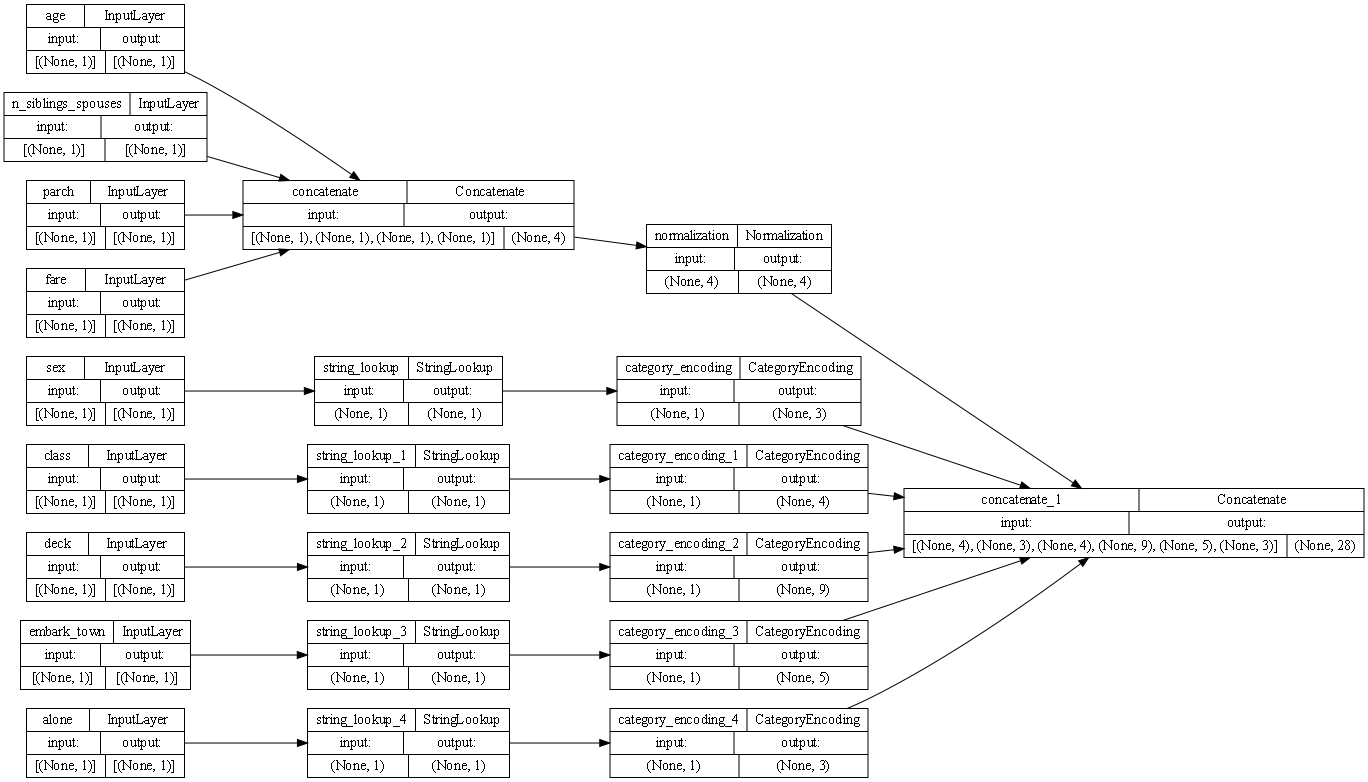

In [5]:
# normaliseer de numerieke kolommen
numeric_inputs = {name:input for name,input in inputs.items()
                  if input.dtype==tf.float32}

x = layers.Concatenate()(list(numeric_inputs.values()))         # groepeer de numerieke kolommen
norm = layers.Normalization()
norm.adapt(np.array(titanic_features[numeric_inputs.keys()]))   # bereken gemiddelde en std per kolom 
all_numeric_inputs = norm(x)                                    # normaliseer de numerieke kolommen
preprocessed_inputs = [all_numeric_inputs]

# categorieke kolommen
for name, input in inputs.items():
  if input.dtype == tf.float32:
    continue

  lookup = layers.StringLookup(vocabulary=np.unique(titanic_features[name]))  # tekst -> ordinal encoding
  one_hot = layers.CategoryEncoding(num_tokens=lookup.vocabulary_size())      # ordinal encoding -> one-hot encoding

  x = lookup(input)
  x = one_hot(x)
  preprocessed_inputs.append(x)

# voeg alles samen tot 1 preprocessing stap die in zijn geheel uitgevoerd kan worden
preprocessed_inputs_cat = layers.Concatenate()(preprocessed_inputs)
titanic_preprocessing = tf.keras.Model(inputs, preprocessed_inputs_cat)

# teken de graaf van dit preprocessing model
tf.keras.utils.plot_model(model = titanic_preprocessing , rankdir="LR", dpi=72, show_shapes=True)
# None in de figuur als eerste waarde in de shapes = het aantal rijen. Dit doet er niet toe voor het model en daarom staat het op None
# Dit hangt af van de data die je erin steekt

In [8]:
# methode 2
from tensorflow.keras import layers

titanic_batches = tf.data.experimental.make_csv_dataset(
    titanic_file, 
    batch_size=4, # batch size 4 is extremely small (use larger sizes in real situations (32 or larger))
#    select_columns=['class', 'fare', 'survived'],  # subset of columns
    label_name="survived")  # this is for splitting the batches in inputs en outputs

[(train_features, label_batch)] = titanic_batches.take(1)
print('Every feature:', list(train_features.keys()))
print('A batch of ages:', train_features['age'])
print('A batch of targets:', label_batch )

# optionally split in train/test (see tf.keras.utils.split_dataset())


# preprocessing mostly if all data can be handled in the same way or for images
# in case of custom processing use map/apply/reduce functions for preprocessing
# layers cannot be used for subset of columns


def get_normalization_layer(name, dataset):
  # Create a Normalization layer for the feature.
  normalizer = layers.Normalization(axis=None)
  # Prepare a Dataset that only yields the feature.
  feature_ds = dataset.map(lambda x, y: x[name])
  # Learn the statistics of the data.
  normalizer.adapt(feature_ds)

  return normalizer

def get_category_encoding_layer(name, dataset, dtype, max_tokens=None):
  # Create a layer that turns strings into integer indices.
  if dtype == 'string':
    index = layers.StringLookup(max_tokens=max_tokens)
  # Otherwise, create a layer that turns integer values into integer indices.
  else:
    index = layers.IntegerLookup(max_tokens=max_tokens)

  feature_ds = dataset.map(lambda x, y: x[name])
  # Learn the set of possible values and assign them a fixed integer index.
  index.adapt(feature_ds)

  # Encode the integer indices.
  encoder = layers.CategoryEncoding(num_tokens=index.vocabulary_size())

  # Apply multi-hot encoding to the indices. The lambda function captures the
  # layer, so you can use them, or include them in the Keras Functional model later.
  return lambda feature: encoder(index(feature))



all_inputs = []  
encoded_features = []

# Numerical features.
for header in ['age', 'n_siblings_spouses', 'parch', 'fare']:
  numeric_col = tf.keras.Input(shape=(1,), name=header)
  normalization_layer = get_normalization_layer(header, titanic_batches)
  encoded_numeric_col = normalization_layer(numeric_col)
  all_inputs.append(numeric_col)                      # important so that the order of the inputs = the order they are concatenated/processed
  encoded_features.append(encoded_numeric_col)        # all layers for performng processing

categorical_cols = ['sex', 'class', 'deck', 'embark_town', 'alone']

for header in categorical_cols:
  categorical_col = tf.keras.Input(shape=(1,), name=header, dtype='string')
  encoding_layer = get_category_encoding_layer(name=header,
                                               dataset=titanic_batches,
                                               dtype='string',
                                               max_tokens=None)
  encoded_categorical_col = encoding_layer(categorical_col)
  all_inputs.append(categorical_col)
  encoded_features.append(encoded_categorical_col)

  
# construct the model
all_features = tf.keras.layers.concatenate(encoded_features)

model = tf.keras.Model(all_inputs, all_features)

tf.keras.utils.plot_model(model = model , rankdir="LR", dpi=72, show_shapes=True)

Every feature: ['sex', 'age', 'n_siblings_spouses', 'parch', 'fare', 'class', 'deck', 'embark_town', 'alone']
A batch of ages: tf.Tensor([28. 28. 19. 40.], shape=(4,), dtype=float32)
A batch of targets: tf.Tensor([0 1 0 0], shape=(4,), dtype=int32)


Door bovenstaande voorbeelden en informatie heb ik de volgende guidelines:

* Werk met tensors voor gestructureerde data
* Werk met tf.data voor niet-gestructureerde data (beelden, video, audio, ...)

## Model opstellen

Er zijn twee methodes om een eenvoudig (zonder lussen) neuraal netwerk op te stellen:
* Sequentieel model
* Functional API

Deze methodes kunnen gecombineerd worden om een model op te bouwen maar voor duidelijkheid en leesbaarheid raad ik aan in je code te kiezen voor 1 methode.

**Sequentieel model**

De eerste mogelijkheid om een model op te bouwen is door gebruik te maken van een sequentieel model.
Hierbij wordt een lijst opgesteld met alle lagen die achter elkaar uitgevoerd moeten worden.
Hierbij is het belangrijk om te realiseren dat de output van een laag steeds de input van de volgende laag is.
Output van vorige lagen kan dus niet gebruikt worden.

In [58]:
# sequentieel model
from tensorflow.keras import models

model = models.Sequential([
  layers.Dense(128, activation='relu', input_shape=(None, 28)),
  layers.Dropout(0.2),
  layers.Dense(1, activation='sigmoid')
])

**Functional API**

De tweede mogelijkheid is om gebruik te maken van de functional API.
Hierbij worden de lagen aan elkaar gekoppeld door middel van functie-oproepen.
Dit maakt het mogelijk om een flexibelere netwerkarchitectuur te bekomen, namelijk kunnen er zo meerdere inputs/outputs, gedeelde lagen en een niet-lineaire topologie gebruikt worden.
Hieronder staat een code-voorbeeld hiervan.

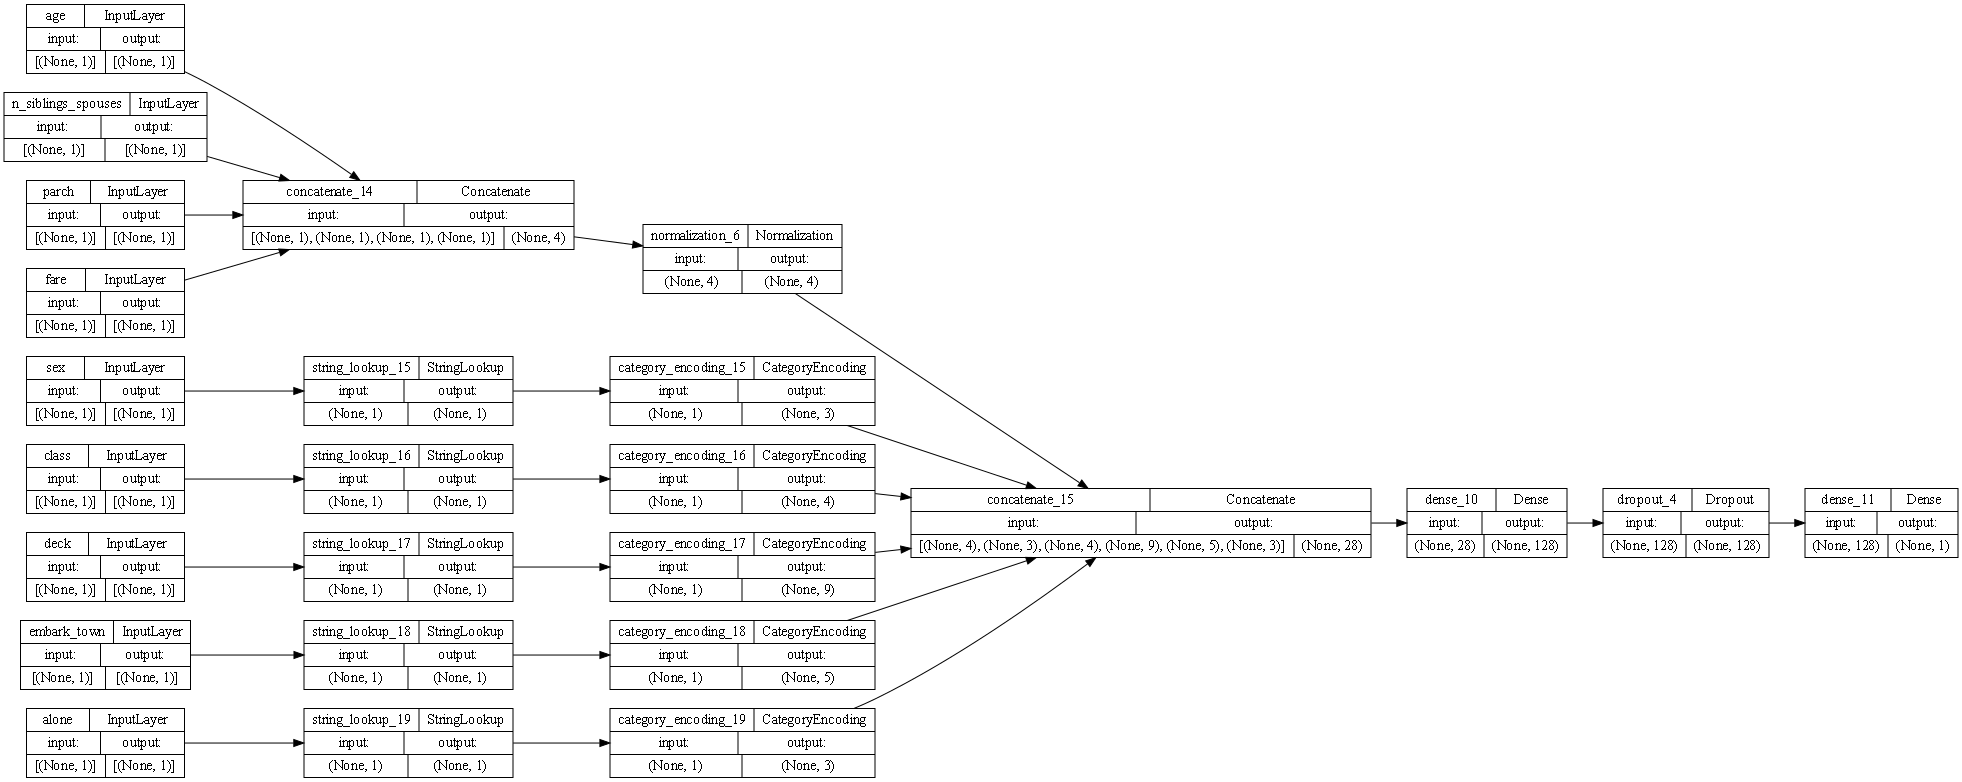

In [60]:
x = layers.Dense(128, activation='relu')(preprocessed_inputs_cat)
x = layers.Dropout(0.2)(x)
x = layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(inputs, x)

tf.keras.utils.plot_model(model = model , rankdir="LR", dpi=72, show_shapes=True)

## Trainen van een model

Na het opstellen van het model, moeten de interne gewichten nog getrained worden. 
Hiervoor moet eerst het model gecompileerd worden. 
Dit gebeurt door de compile() functie waarbij de volgende belangrijke parameters ingesteld moeten worden:
* De gekozen lossfunctie: dit is de functie waarvoor de gewichten geoptimaliseerd worden.
* De optimizer: Dit is hoe de learning rate aangepast wordt
* De metrieken: Dit is welke metrieken mee opgenomen worden voor evaluatie (niet rechtstreeks een impact op het leerproces)

Na compilatie is het mogelijk om met de summary() functie een overzicht te krijgen van het model.
Dit kan goed gebruikt worden om de output dimensies van de verschillende lagen te bekijken en het aantal te trainen parameters.

Nu kunnen de gewichten getrained worden door middel van de .fit() functie.
Naast de input en gewenste output mee te geven moeten ook de volgende waarden ingesteld worden:
* epochs: Het aantal epochs of het aantal keer dat de volledige dataset gebruikt wordt voor training
* batch_dize: De grootte van de groepen die doorheen het model gaan voor de gewichten aangepast worden.
* Validation_size: Percent van de data dat gebruikt wordt voor validatie

Het aantal epochs moet groter zijn als er meer gewichten te trainen zijn en als er minder data beschikbaar is.
Dit is vooral het geval bij niet-gestructureerde data en minder bij gestructureerde.
De batch_size heeft geen grote impact op de behaalde resultaten maar wel op de snelheid waarmee deze gehaald worden.

In [70]:
# model trainen
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.RMSprop(),
    metrics=[tf.keras.metrics.BinaryAccuracy()],
)

model.summary()

history = model.fit(x=titanic_features_dict, y=titanic_labels, batch_size=32, epochs=200)

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 age (InputLayer)            [(None, 1)]                  0         []                            
                                                                                                  
 n_siblings_spouses (InputL  [(None, 1)]                  0         []                            
 ayer)                                                                                            
                                                                                                  
 parch (InputLayer)          [(None, 1)]                  0         []                            
                                                                                                  
 fare (InputLayer)           [(None, 1)]                  0         []                      

## Model evaluatie

In de laatste stap moet het model nog gevalueerd worden.
Dit kan door middel van de historiek die door het trainingsproces teruggegeven wordt.
Hieruit kan heel wat data gehaald worden maar kunnen ook plotjes getekend worden.

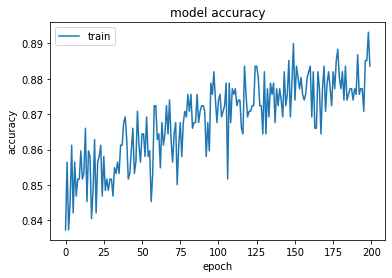

In [71]:
# plot histogram
import matplotlib.pyplot as plt

plt.plot(history.history['binary_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

## Callbacks

Een andere belangrijke optie van het leerproces die nog niet vermeld is, is het toevoegen van callbacks.
Dit is extra functionaliteit die kan uitgevoerd worden na het uitvoeren van elke batch, elke epoch, elke trainingsrun, elke voorspelling, ...
Deze callbacks kunnen gebruikt worden om bijvoorbeeld het leeproces te onderbreken wanneer overfitting gedetecteerd wordt, backups gemaakt worden na een aantal epochs in het geval er fouten zouden optreden of voor logging naar tensorboard.
Hieronder zie je een voorbeeld van dit laatste.

In [73]:
# model trainen
callbacks = [
    tf.keras.callbacks.TensorBoard(
        log_dir="./logs",
        histogram_freq=1,       # How often to log histogram visualizationss
        update_freq="epoch",
        profile_batch=10
    ) 
]

history = model.fit(x=titanic_features_dict, y=titanic_labels, callbacks=callbacks, batch_size=32, epochs=2000)

Epoch 1/2000
20/20 [==============================] - 0s 7ms/step - loss: 0.2539 - binary_accuracy: 0.9059
Epoch 2/2000
20/20 [==============================] - 0s 3ms/step - loss: 0.2494 - binary_accuracy: 0.9043
Epoch 3/2000
20/20 [==============================] - 0s 3ms/step - loss: 0.2476 - binary_accuracy: 0.9027
Epoch 4/2000
20/20 [==============================] - 0s 3ms/step - loss: 0.2413 - binary_accuracy: 0.9011
Epoch 5/2000
20/20 [==============================] - 0s 3ms/step - loss: 0.2436 - binary_accuracy: 0.8995
Epoch 6/2000
20/20 [==============================] - 0s 2ms/step - loss: 0.2367 - binary_accuracy: 0.8995
Epoch 7/2000
20/20 [==============================] - 0s 3ms/step - loss: 0.2372 - binary_accuracy: 0.9027
Epoch 8/2000
20/20 [==============================] - 0s 3ms/step - loss: 0.2596 - binary_accuracy: 0.8947
Epoch 9/2000
20/20 [==============================] - 0s 3ms/step - loss: 0.2304 - binary_accuracy: 0.9107
Epoch 10/2000
20/20 [================